# This code will perform data exploration on the dataset of ACLforces

In [1]:
import os
cwd = os.getcwd()
import seaborn as sns
import pandas as pd
import numpy as np
from opensim_utils_g import readMotionFile
import matplotlib.pyplot as plt
import perform_opensim_analyses_ACL
import AssignPropertiesCustomLigament


D:\LocalDisk\Programs\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\matplotlib\__init__.py:1354: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
subjects = ['Ahelaos','Amanda','Celine','CharlotteH','CharlotteV','Esther','Filip',\
           'Franceska','Guido','Jeroen']
length = len(subjects)

In [3]:
%load_ext autoreload
%autoreload 1
%aimport opensim_utils_g
%aimport perform_opensim_analyses_ACL
%matplotlib inline

In [4]:
#for i in range(0,1):
#    name = subjects[i]
#    m = cwd+'/Data/'+name+'/'+name+'_2.osim'
#    AssignPropertiesCustomLigament.change_properies(m,cwd+'/Data/swing_model.osim')
                                                            

In [5]:
#for i in range(0,length):
#    name = subjects[i]
#    model = cwd+'/Data/'+name+'/'+name+'_2CL.osim' 
#    perform_opensim_analyses_ACL.Opensim_Analysis(model)

## Gather all data in one matrix. Different columns will be moments and rows will be acl_r (a and p) from every subject.

In [68]:
array_subj = []
for i in range(0,length):
    acl_r=[]
    joint_mom=[]
    acl_jm_kcf=[]
    array_trials=[]
    kcf = []
    name = subjects[i]
    results_dir = cwd+'/Data/'+name+'/Results'
    subj_dir = os.path.dirname(results_dir)
    """ACL data"""
    for k in range(1,4):
        events_file = pd.read_excel(subj_dir+'/'+name+'_HDR_'+str(k)+'_Events.xls')
        init_time = events_file.InitialContactTime.iloc[0]
        final_time = events_file.TimeLowestCOMX.iloc[1]
        """Load kinematics"""
        ik_header, ik_labels, ik_data = readMotionFile(results_dir+'/HDR_'+str(k)+'_IK.mot')
        ik_d = np.array(ik_data)
        time = ik_d[:,0]
        timeList = time.tolist()
        idx3 = timeList.index(init_time)
        idx4 = timeList.index(final_time)
        array3 = ik_d[idx3:idx4+1,31:34]#lumbar
        array7 = ik_d[idx3:idx4+1,7:11]
        array5 = ik_d[idx3:idx4+1,13]*-1#anterior-posterior
        array5 = array5.reshape(len(array5),1)
        array4 = ik_d[idx3:idx4+1,16]
        array4 = array4.reshape(len(array4),1)
        joint_ang = np.concatenate((array3,array7,array5,array4),axis=1)
        """Load the acl forces"""
        so_header, so_labels, so_data = readMotionFile(results_dir+'/'+name+'_2CL_HDR_'+str(k)+'_StaticOptimization_force.sto')
        idx1 = so_labels.index('aACL_R')
        idx2 = so_labels.index('pACL_R')
        aACL_R_data = np.array([row[idx1] for row in so_data])
        pACL_R_data = np.array([row[idx2] for row in so_data])
        acl_r = aACL_R_data+pACL_R_data
        acl_r = acl_r.reshape(len(acl_r),1)
        """Load the joint moments"""
        id_header, id_labels, id_data = readMotionFile(results_dir+'/HDR_'+str(k)+'_ID.sto')
        id_d = np.array(id_data)
        array1 = id_d[:,1:4]
        array2 = id_d[:,7:13]
        array6 = id_d[:,16:19]
        joint_mom= np.concatenate((array1,array2,array6),axis=1)
        """Load the knee reaction forces"""
        jra_header, jra_labels, jra_data = readMotionFile(results_dir+'/'+name+'_2CL_HDR_'+str(k)+'_JointReaction_ReactionLoads.sto')
        j_data = np.array(jra_data)
        kcf = j_data[:,19:22]
        """Concatenate the acl forces array with the joint moments array"""
        acl_jm_kcf_ja = np.concatenate((acl_r,joint_mom,kcf,joint_ang),axis=1)
        """Create the complete array for all three trials"""
        if k==1:
            array_trials = acl_jm_kcf_ja
        else:
            array_trials = np.concatenate((array_trials,acl_jm_kcf_ja),axis=0)
    """Create the array for all subjects"""
    if i==0:
        array_subj = array_trials
    else:
        array_subj = np.concatenate((array_subj,array_trials),axis=0)


In [71]:
lb

['acl_r',
 'pelvis_tilt_moment',
 'pelvis_list_moment',
 'pelvis_rotation_moment',
 'hip_flexion_r_moment',
 'hip_adduction_r_moment',
 'hip_rotation_r_moment',
 'knee_angle_r_moment',
 'knee_adduction_r_moment',
 'knee_rotation_r_moment',
 'ankle_angle_r_moment',
 'subtalar_angle_r_moment',
 'mtp_angle_r_moment',
 'KCF_X',
 'KCF_Y',
 'KCF_Z',
 'lumbar_extension',
 'lumbar_bending',
 'lumbar_rotation',
 'hip_flexion_r',
 'hip_adduction_r',
 'hip_rotation_r',
 'knee_angle_r',
 'knee_anterior_posterior_r',
 'ankle_angle_r']

In [70]:
"""Create the labels and the complete dataframe"""
str1 = id_labels[1:4]
str1.insert(0,'acl_r')
lb = str1+id_labels[7:13]+id_labels[16:19]+['KCF_X','KCF_Y','KCF_Z']+ik_labels[31:34]+ik_labels[7:11]+[ik_labels[13]]+[ik_labels[16]]
df = pd.DataFrame(array_subj,columns = lb)
df.shape

(603, 25)

## Pearson correlation heatmap

In [72]:
corr_matrix_pearson=df.corr()
corr_matrix_spearman = df.corr(method='spearman')

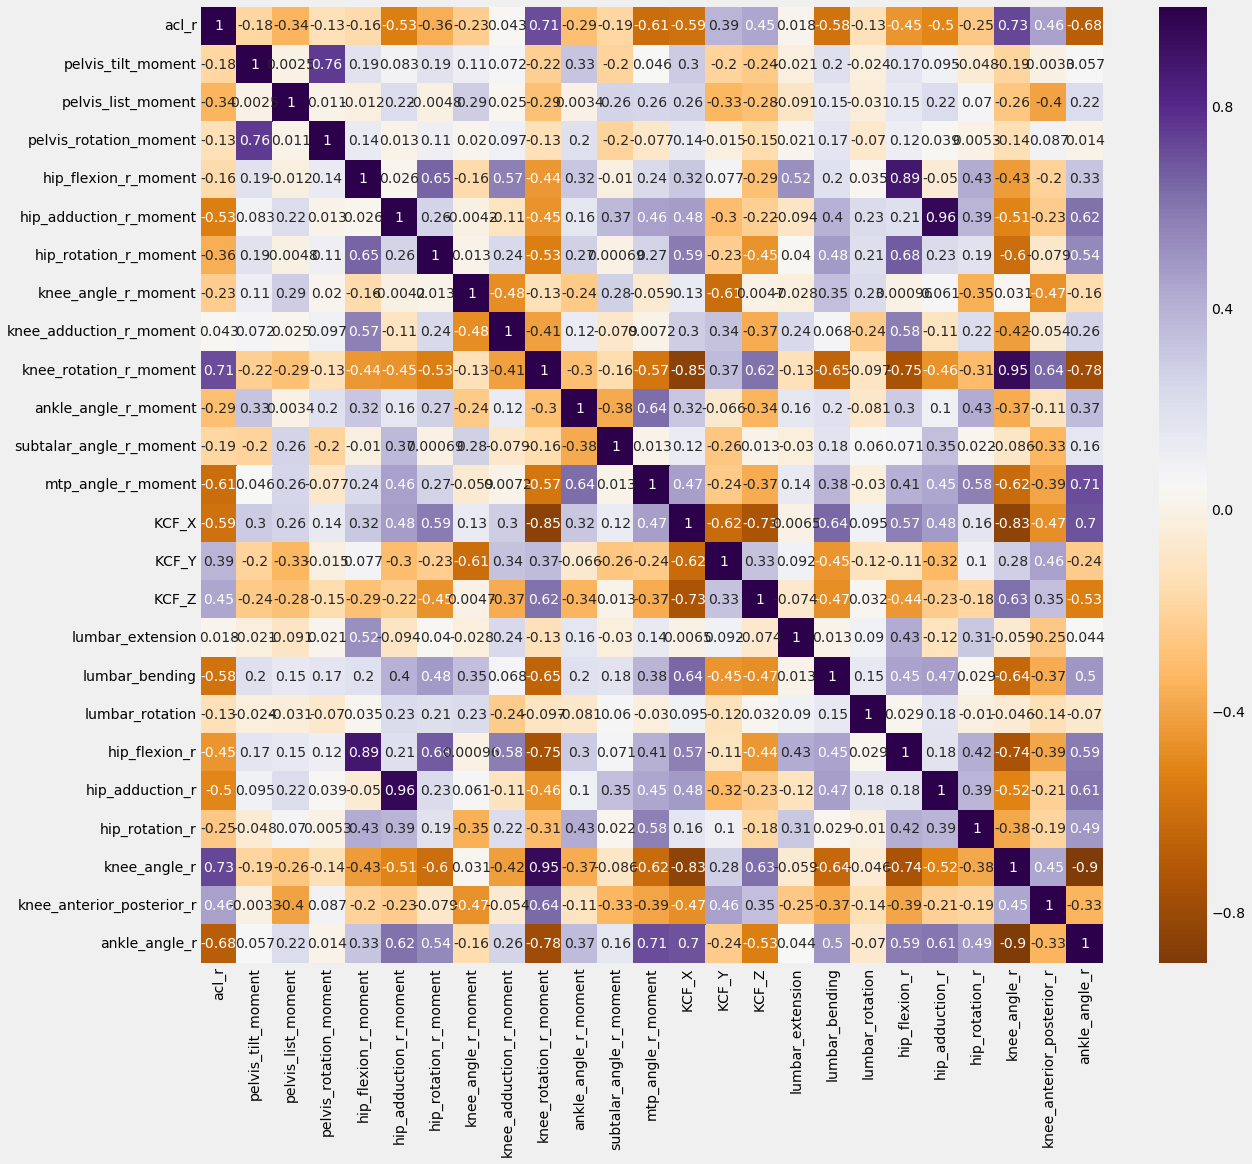

In [74]:
plt.figure(figsize=(18,16))
sns.heatmap(corr_matrix_pearson,annot=True, cmap='PuOr')

In [75]:
#Correlation with output variable
cor_target = (corr_matrix_pearson["acl_r"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.6]
relevant_features

acl_r                     1.000000
knee_rotation_r_moment    0.713632
knee_angle_r              0.730770
Name: acl_r, dtype: float64

## Spearman correlation heatmap

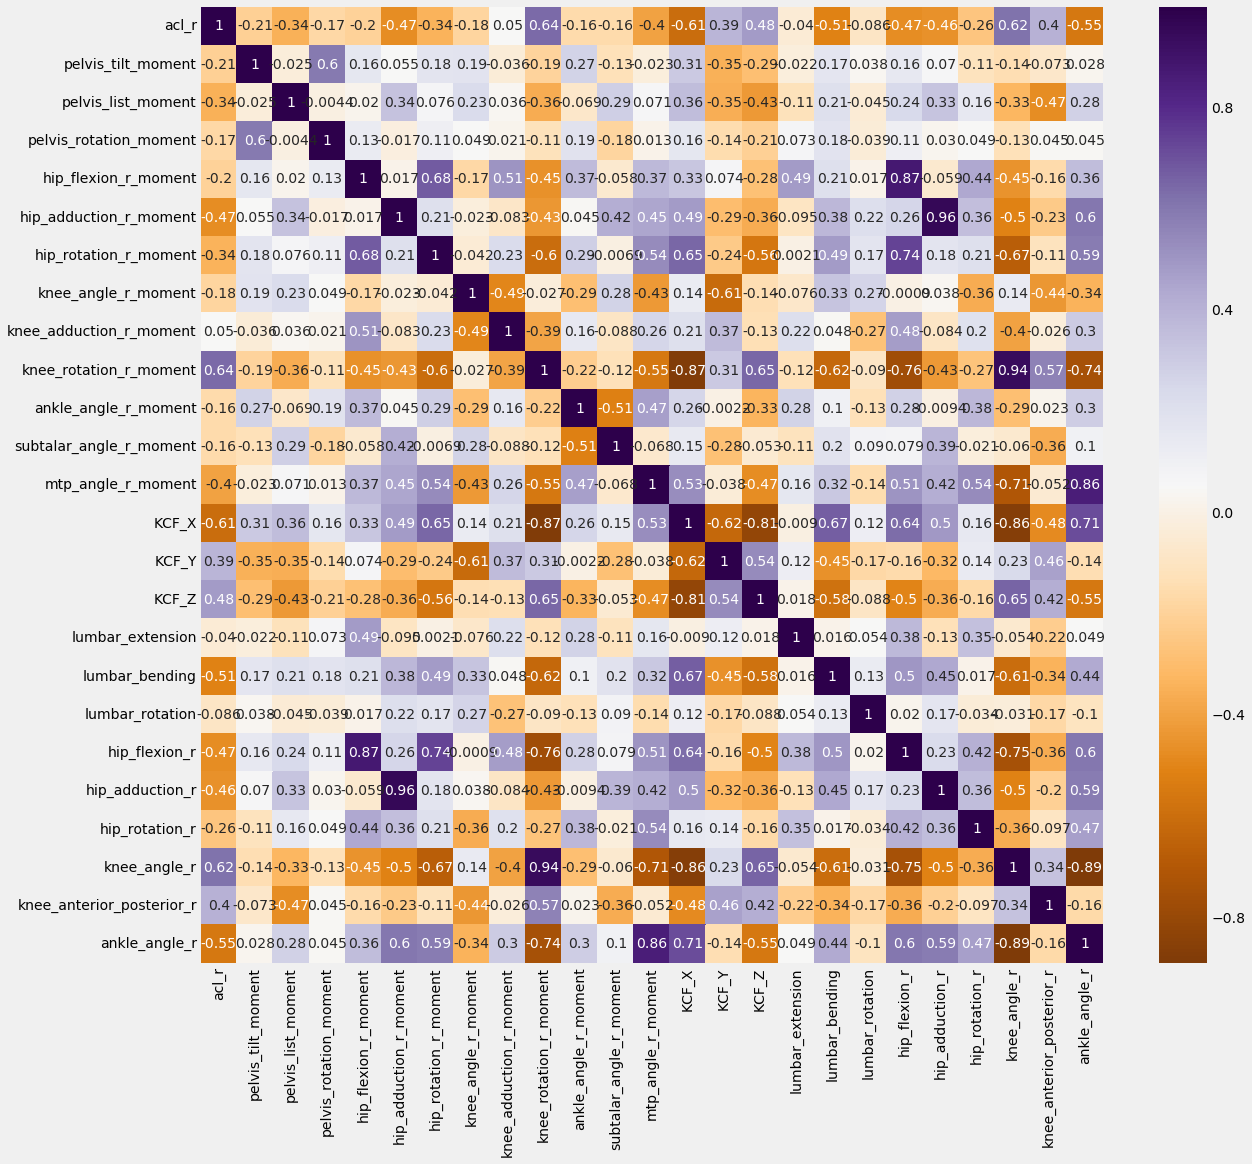

In [77]:
plt.figure(figsize=(18,16))
sns.heatmap(corr_matrix_spearman,annot=True, cmap='PuOr')

# Further data exploration

### Linear regression

In [80]:
import statsmodels.api as sm

ImportError: cannot import name ss

In [79]:
y = df['acl_r']

In [27]:
X = df.drop(['acl_r'],axis=1)

In [28]:
## Without a constant

import statsmodels.api as sm

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  acl_r   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     94.85
Date:                Tue, 14 Jan 2020   Prob (F-statistic):          7.61e-183
Time:                        13:44:23   Log-Likelihood:                -3078.1
No. Observations:                 603   AIC:                             6204.
Df Residuals:                     579   BIC:                             6310.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
pelvis_tilt_moment           -0.0316      0.047     -0.670      0.503        -0.124     0.061
pelvis_list_moment           -0.0503      0.055     -0.907      0.365        -0.159     0.059
pelvis_rotation_moment       -0.2999      0.209     -1.437      0.151        -0.710     0.110
hip_flexion_r_moment         -0.0326      0.020     -1.631      0.103        -0.072     0.007
hip_adduction_r_moment       -0.0749      0.009     -8.442      0.000        -0.092    -0.057
hip_rotation_r_moment         0.1061      0.058      1.842      0.066        -0.007     0.219
knee_angle_r_moment          -0.0155      0.010     -1.499      0.134        -0.036     0.005
knee_adduction_r_moment       0.0332      0.036      0.923      0.356        -0.037     0.104
knee_rotation_r_moment        0.0032      0.039      0.081      0.936        -0.074     0.080
ankle_angle_r_moment          0.1568      0.063      2.482      0.013         0.033     0.281
subtalar_angle_r_moment      -0.3266      0.164     -1.995      0.046        -0.648    -0.005
mtp_angle_r_moment           -3.7217      0.689     -5.403      0.000        -5.075    -2.369
KCF_X                         0.0129      0.002      6.766      0.000         0.009     0.017
KCF_Y                         0.0115      0.002      5.076      0.000         0.007     0.016
KCF_Z                         0.0375      0.008      4.413      0.000         0.021     0.054
pelvis_tilt                   1.3688      1.241      1.103      0.271        -1.070     3.807
pelvis_list                  10.6959      2.142      4.993      0.000         6.489    14.903
pelvis_rotation               0.4786      0.540      0.886      0.376        -0.583     1.540
hip_flexion_r                 6.5027      1.783      3.646      0.000         3.000    10.005
hip_adduction_r              19.1738      2.483      7.722      0.000        14.297    24.051
hip_rotation_r               -2.3704      1.236     -1.918      0.056        -4.798     0.057
knee_angle_r                  7.1859      1.293      5.556      0.000         4.646     9.726
knee_anterior_posterior_r -2250.9320    702.771     -3.203      0.001     -3631.223  -870.641
ankle_angle_r                 1.0250      0.530      1.934      0.054        -0.016     2.066
==============================================================================
Omnibus:                      280.867   Durbin-Watson:                   0.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3173.071
Skew:                           1.761   Prob(JB):                         0.00
Kurtosis:                      13.672   Cond. No.                     4.21e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the

### Now we add an intercept

In [29]:
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  acl_r   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     78.47
Date:                Tue, 14 Jan 2020   Prob (F-statistic):          2.77e-164
Time:                        13:44:30   Log-Likelihood:                -3054.8
No. Observations:                 603   AIC:                             6160.
Df Residuals:                     578   BIC:                             6270.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
const                       576.5911     84.703      6.807      0.000       410.229   742.953
pelvis_tilt_moment           -0.0519      0.046     -1.139      0.255        -0.141     0.038
pelvis_list_moment           -0.0770      0.054     -1.437      0.151        -0.182     0.028
pelvis_rotation_moment       -0.2536      0.201     -1.261      0.208        -0.649     0.142
hip_flexion_r_moment          0.0171      0.021      0.831      0.406        -0.023     0.058
hip_adduction_r_moment       -0.0599      0.009     -6.786      0.000        -0.077    -0.043
hip_rotation_r_moment         0.0599      0.056      1.072      0.284        -0.050     0.170
knee_angle_r_moment          -0.0099      0.010     -0.988      0.324        -0.030     0.010
knee_adduction_r_moment       0.2481      0.047      5.296      0.000         0.156     0.340
knee_rotation_r_moment        0.0279      0.038      0.738      0.461        -0.046     0.102
ankle_angle_r_moment          0.0671      0.062      1.078      0.281        -0.055     0.189
subtalar_angle_r_moment      -0.4422      0.159     -2.789      0.005        -0.754    -0.131
mtp_angle_r_moment           -2.5265      0.686     -3.682      0.000        -3.874    -1.179
KCF_X                         0.0086      0.002      4.431      0.000         0.005     0.012
KCF_Y                         0.0038      0.002      1.527      0.127        -0.001     0.009
KCF_Z                         0.0419      0.008      5.104      0.000         0.026     0.058
pelvis_tilt                   1.2114      1.196      1.013      0.311        -1.137     3.560
pelvis_list                   3.7130      2.304      1.612      0.108        -0.812     8.238
pelvis_rotation              -0.0246      0.526     -0.047      0.963        -1.057     1.008
hip_flexion_r                 0.1031      1.958      0.053      0.958        -3.742     3.949
hip_adduction_r              12.7921      2.568      4.981      0.000         7.748    17.837
hip_rotation_r               -1.1580      1.204     -0.962      0.336        -3.522     1.206
knee_angle_r                  5.4652      1.271      4.300      0.000         2.969     7.962
knee_anterior_posterior_r -1669.2258    682.147     -2.447      0.015     -3009.014  -329.437
ankle_angle_r                 1.2742      0.512      2.490      0.013         0.269     2.279
==============================================================================
Omnibus:                      286.487   Durbin-Watson:                   0.775
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3726.735
Skew:                           1.758   Prob(JB):                         0.00
Kurtosis:                      14.661   Cond. No.                     4.25e+06
========================================================

## Now we employ a random forest algorithm to find the most important feature

In [81]:
from sklearn.cross_validation  import train_test_split

In [82]:
df.shape

(603, 25)

In [83]:
y = df['acl_r']

In [84]:
X = df.drop(['acl_r'],axis=1)#feature list
X.head()

,pelvis_tilt_moment,pelvis_list_moment,pelvis_rotation_moment,hip_flexion_r_moment,hip_adduction_r_moment,hip_rotation_r_moment,knee_angle_r_moment,knee_adduction_r_moment,knee_rotation_r_moment,ankle_angle_r_moment,...,KCF_Z,lumbar_extension,lumbar_bending,lumbar_rotation,hip_flexion_r,hip_adduction_r,hip_rotation_r,knee_angle_r,knee_anterior_posterior_r,ankle_angle_r
0,24.161893,-78.390506,11.817885,-2058.836179,-3169.620854,566.742575,5162.840186,-1599.677415,-74.464797,-138.983595,...,116.587597,-31.935843,-1.230907,-1.835865,13.159312,-8.171138,-9.369979,-19.646183,0.005266,-20.421358
1,-302.034719,-179.632009,-52.878186,-2333.296434,-3016.767991,644.558802,5594.078961,-1803.806978,-250.061973,-119.931969,...,266.543143,-32.488091,-0.342815,-1.183096,14.515924,-7.119263,-12.309192,-26.125428,-0.009679,-14.601721
2,-54.490100,81.207786,-16.734197,-1881.276019,-2354.175045,587.750422,6020.283803,-1616.812296,-396.375438,-112.401737,...,-206.392123,-32.121132,-0.340441,0.042969,19.671435,-6.774063,-9.316728,-34.876403,-0.013694,-12.316137
3,-43.225700,-34.361250,-8.170721,-1745.425212,-2183.560855,627.738404,6259.571724,-1667.574974,-558.331416,-103.912720,...,-74.246995,-32.219167,0.838950,1.855638,23.224491,-3.648728,-4.727208,-41.246277,-0.013803,-10.924234
4,25.861640,-56.261728,5.832140,-1536.301319,-1948.231316,656.783487,6417.342402,-1662.951297,-707.101303,-97.382921,...,-42.859582,-32.622028,2.553274,2.735696,25.154920,-0.878219,-3.833469,-45.746437,-0.012490,-8.570429


In [85]:
#np.random.seed(seed = 42)
#X['random'] = np.random.random(size = len(X))

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [87]:
X_train.shape

(482, 24)

In [88]:
from sklearn.ensemble import RandomForestRegressor

In [89]:
rf = RandomForestRegressor(n_estimators = 1000,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)

In [90]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [91]:
rf.score(X_test, y_test)

0.8536346589627188

In [92]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test, y_test)))

R^2 Training Score: 0.99 
OOB Score: 0.90 
R^2 Validation Score: 0.85


## Well, there is some overfitting in the model, as it performs much worse on OOB sample and worse on the validation set

In [93]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_list = list(X.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print[('Variable: {:20} Importance: {} '.format(*pair)) for pair in feature_importances]

['Variable: knee_rotation_r_moment Importance: 0.48 ', 'Variable: knee_angle_r         Importance: 0.31 ', 'Variable: hip_adduction_r_moment Importance: 0.03 ', 'Variable: hip_flexion_r_moment Importance: 0.02 ', 'Variable: knee_angle_r_moment  Importance: 0.02 ', 'Variable: ankle_angle_r_moment Importance: 0.02 ', 'Variable: lumbar_extension     Importance: 0.02 ', 'Variable: knee_anterior_posterior_r Importance: 0.02 ', 'Variable: knee_adduction_r_moment Importance: 0.01 ', 'Variable: subtalar_angle_r_moment Importance: 0.01 ', 'Variable: KCF_Z                Importance: 0.01 ', 'Variable: lumbar_bending       Importance: 0.01 ', 'Variable: lumbar_rotation      Importance: 0.01 ', 'Variable: ankle_angle_r        Importance: 0.01 ', 'Variable: pelvis_tilt_moment   Importance: 0.0 ', 'Variable: pelvis_list_moment   Importance: 0.0 ', 'Variable: pelvis_rotation_moment Importance: 0.0 ', 'Variable: hip_rotation_r_moment Importance: 0.0 ', 'Variable: mtp_angle_r_moment   Importance: 0.0 '

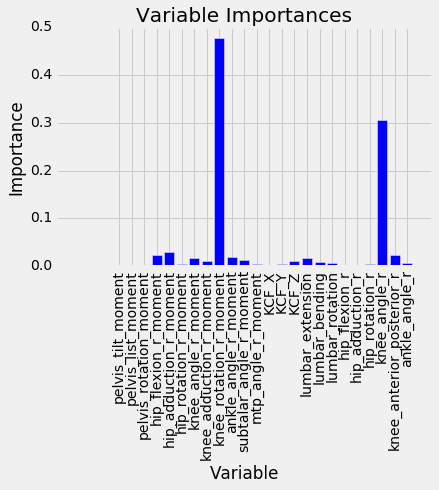

In [94]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical',align="center")
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## Now we re-run the analysis with the first 6 most important features

In [111]:
low_features = []
for i in range(8,len(feature_importances)):
    low_features.append(feature_importances[i][0])


In [112]:
low_features.append('acl_r')

In [113]:
X = df.drop((low_features),axis=1)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [115]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                             rf.oob_score_,
                                                                                             rf.score(X_test, y_test)))

R^2 Training Score: 0.99 
OOB Score: 0.91 
R^2 Validation Score: 0.85


In [116]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_list = list(X.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print[('Variable: {:20} Importance: {} '.format(*pair)) for pair in feature_importances]

['Variable: knee_rotation_r_moment Importance: 0.48 ', 'Variable: knee_angle_r         Importance: 0.32 ', 'Variable: hip_flexion_r_moment Importance: 0.04 ', 'Variable: hip_adduction_r_moment Importance: 0.04 ', 'Variable: knee_angle_r_moment  Importance: 0.03 ', 'Variable: ankle_angle_r_moment Importance: 0.03 ', 'Variable: lumbar_extension     Importance: 0.03 ', 'Variable: knee_anterior_posterior_r Importance: 0.03 ']


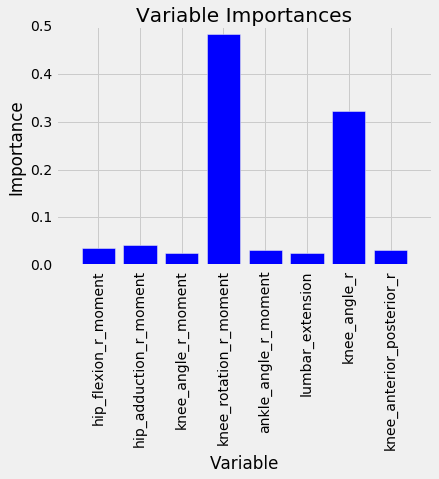

In [117]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical',align="center")
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

## Permutation importances tools - rfpimp and elif

In [118]:
y = df['acl_r']
X = df.drop(['acl_r'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [119]:
rf = RandomForestRegressor(n_estimators = 1000,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [120]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, r2)

In [121]:
perm_imp_rfpimp


,Importance
Feature,
knee_rotation_r_moment,0.429848
knee_angle_r,0.333871
hip_flexion_r_moment,0.052865
knee_anterior_posterior_r,0.030050
hip_adduction_r_moment,0.028904
KCF_Z,0.013467
knee_angle_r_moment,0.011537
lumbar_extension,0.009912
ankle_angle_r_moment,0.009582


ValueError: could not convert string to float: Importance

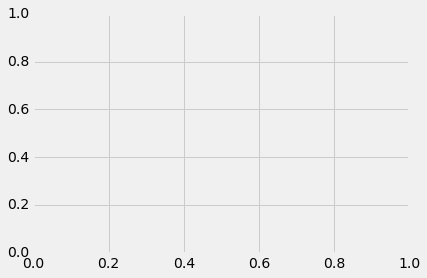

In [122]:
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(perm_imp_rfpimp)))
# Make a bar chart
plt.bar(x_values, perm_imp_rfpimp, orientation = 'vertical',align="center")
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');